# Motion Recognition

### The problem:

*The three dimensional coordinates of each of 38 joints on the humanoid OptimuS-VD robot were recorded as it performed 3 different movements: walking, running, and jumping. The goal is to design an algorithm that given a recording of a movement can identify which movement is being performed.*

### The solution:

Principal component analysis was used to reduce the dimensionality of the data to 6% of the original dimensions while still capturing 95% of the dataset’s information. Each movement was found to have a distinct structure in PCA space, and using
the centroid of each movement an algorithm was developed to predict the movement being performed by new samples with a stable accuracy of 95%.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go

# Training Data Location
folder = "hw2data/train/"


In [2]:
# Create X_train

files = os.listdir(folder)

names = ["walking", "running", "jumping"]

x_train = []
for action in names:
    for i in range(1, 6):
        file_path = os.path.join(folder, action + "_" + str(i) + ".npy")
        x_train.append(np.load(file_path))

x_train = np.hstack(x_train)

print(x_train.shape)

(114, 1500)


In [3]:
# Center the Data
centered_data = x_train - np.mean(x_train, axis=1)[:, None] 

# Perform SVD
dU, ds, dVt = np.linalg.svd(centered_data)
print(dU.shape, ds.shape, dVt.shape)

(114, 114) (114,) (1500, 1500)


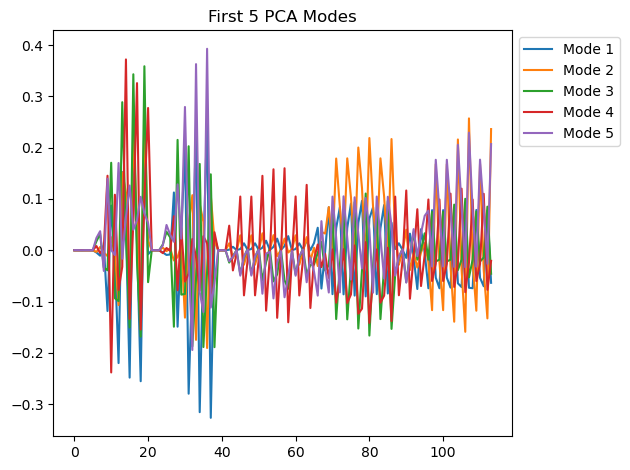

In [4]:
# Plot first 5 PCA Modes in PCA Space

for m in range(0, 5):
    plt.plot(np.arange(0, 114), dU[:,m], label="Mode " + str(m + 1))
plt.title("First 5 PCA Modes")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_17476\4103321990.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


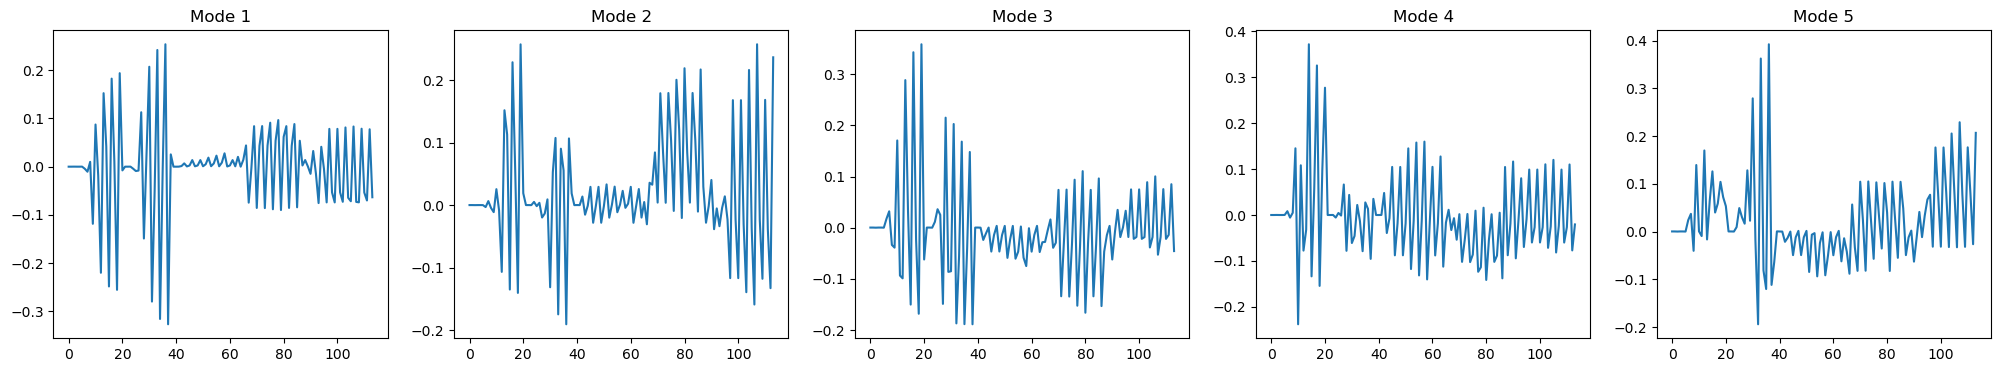

In [5]:
# Plot each mode individually in PCA space

fig, axs = plt.subplots(1, 5, figsize=(25, 4))
for m in range(0, 5):
    axs[m].plot(dU[:, m])
    axs[m].set_title("Mode " + str(m + 1))
fig.show()

Text(0, 0.5, 'Cumulative Energy')

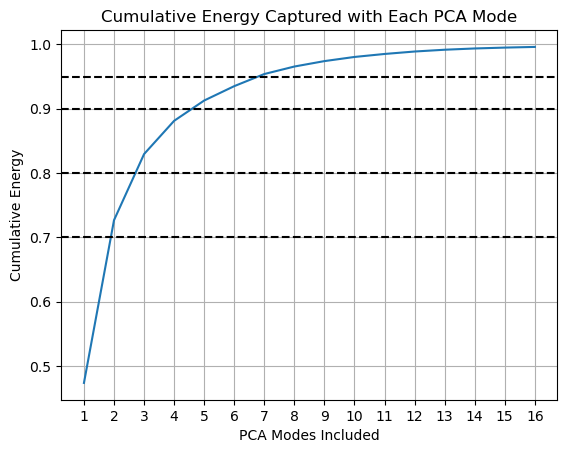

In [6]:
# Calculate and plot cumulative energy
E = np.power(ds,2)/np.sum(np.power(ds,2))
plt.plot(np.arange(1, 17, 1), np.cumsum(E)[:16])
plt.axhline(y=0.7, color="k", linestyle="--")
plt.axhline(y=0.8, color="k", linestyle="--")
plt.axhline(y=0.9, color="k", linestyle="--")
plt.axhline(y=0.95, color="k", linestyle="--")
plt.xticks(np.arange(1, 17, 1))
plt.grid(True)
plt.title("Cumulative Energy Captured with Each PCA Mode")
plt.xlabel('PCA Modes Included')
plt.ylabel('Cumulative Energy')

In [7]:
# Project x_train to each of the first 3 modes

pca1 = dU[:,0] @ x_train
pca2 = dU[:,1] @ x_train
pca3 = dU[:,2] @ x_train

pca2.shape

(1500,)

Text(0, 0.5, 'PCA Mode 2')

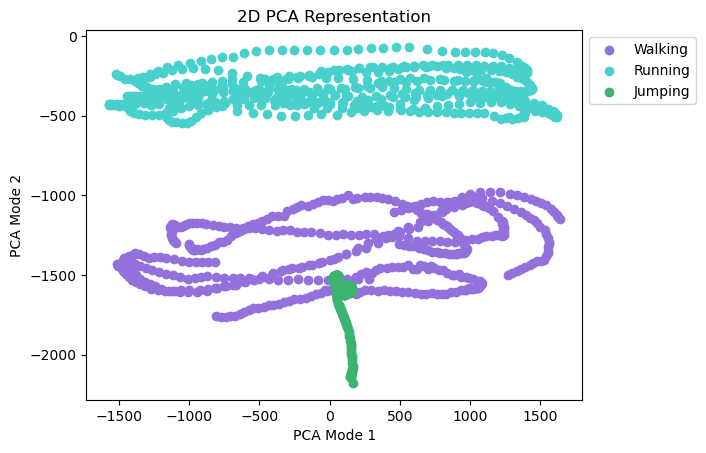

In [8]:
# Plot 2D Representation of x_train

plt.title("2D PCA Representation")
plt.scatter(pca1[:500], pca2[:500], c="mediumpurple")
plt.scatter(pca1[500:1000], pca2[500:1000], c="mediumturquoise")
plt.scatter(pca1[1000:], pca2[1000:], c="mediumseagreen")
plt.legend([name.capitalize() for name in names], loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("PCA Mode 1")
plt.ylabel("PCA Mode 2")

In [9]:
# Label dataset by movement, serves as ground truth labels for training

labels = np.hstack((np.full(500, 0), np.full(500, 1), np.full(500, 2)))

In [10]:
# Plot 3D Representation of x_train

unique_labels = np.unique(labels)

# Create separate traces for each movement
traces = []
for l in unique_labels:
    mask = (labels == l)
    trace = go.Scatter3d(x=pca1[mask], y=pca2[mask], z=pca3[mask],
                         mode='markers', marker=dict(size=2),
                         name=names[l].capitalize())
    traces.append(trace)

layout = go.Layout(scene=dict(
        xaxis_title='PCA Mode 1',
        yaxis_title='PCA Mode 2',
        zaxis_title='PCA Mode 3'))

fig = go.Figure(data=traces, layout=layout)

fig.update_layout(legend=dict(itemsizing='constant', itemwidth=40))

fig.show()

In [11]:
three_m_pca = np.vstack([pca1, pca2, pca3])
# Divide the projection by movement
walk = three_m_pca[:, 0:500]
run = three_m_pca[:, 500:1000]
jump = three_m_pca[:, 1000:]

# Determine centroid for each movement
moves = [walk, run, jump]
cntds = []
for m in moves:
    cntd = np.mean(m, 1)
    cntds.append(cntd)
xc, yc, zc = zip(*cntds)

In [12]:
# Plot 3D Representation of x_train with centroids

unique_labels = np.unique(labels)

# Create separate traces for each movement
traces = []
for l in unique_labels:
    mask = (labels == l)
    trace = go.Scatter3d(x=pca1[mask], y=pca2[mask], z=pca3[mask],
                         mode='markers', marker=dict(size=2),
                         name=names[l].capitalize())
    traces.append(trace)

centers = go.Scatter3d(x=xc, y=yc, z=zc, mode="markers", 
                       marker=dict(size=4), name="Centroids")
traces.append(centers)

layout = go.Layout(scene=dict(
        xaxis_title='PCA Mode 1',
        yaxis_title='PCA Mode 2',
        zaxis_title='PCA Mode 3'))

fig = go.Figure(data=traces, layout=layout)

fig.update_layout(legend=dict(itemsizing='constant', itemwidth=40))

fig.show()

In [13]:
# Determine optimal k for categorization training
scores = []

# Project x_train onto k modes pca space
pca_project = np.dot(dU.T, x_train)

# Determine accuracy score for each k
for k in range(1, 114):

    k_m_pca = pca_project[0:k, :]
    
    # Divide the projection by movement
    walking, running, jumping = np.split(k_m_pca, [500, 1000], axis=1)

    # Determine centroid for each movement
    centroids = np.array([np.mean(m, axis=1) for m in [walking, running, jumping]])

    # For each sample assign label based on closest centroids in pca space
    dists = []
    for c in centroids:
        dists.append(np.linalg.norm(k_m_pca.T - c, axis=1))
    train_labels = np.argmin(dists, axis=0)

    # Calculate accuracy score
    scores.append(accuracy_score(labels, train_labels))

In [14]:
print(np.dot(dU.T, dU))

[[ 1.00000000e+00  3.40520148e-18  1.37451773e-16 ...  2.25618308e-18
  -5.24098257e-18  2.90928169e-17]
 [ 3.40520148e-18  1.00000000e+00 -8.29172463e-17 ...  4.62823875e-20
  -4.11374595e-17  8.17522669e-17]
 [ 1.37451773e-16 -8.29172463e-17  1.00000000e+00 ...  6.26268517e-19
   1.45884381e-17  8.88462647e-18]
 ...
 [ 2.25618308e-18  4.62823875e-20  6.26268517e-19 ...  1.00000000e+00
  -1.96048773e-16  1.15469171e-17]
 [-5.24098257e-18 -4.11374595e-17  1.45884381e-17 ... -1.96048773e-16
   1.00000000e+00 -9.57716537e-17]
 [ 2.90928169e-17  8.17522669e-17  8.88462647e-18 ...  1.15469171e-17
  -9.57716537e-17  1.00000000e+00]]


Text(0.5, 1.0, 'Training Accuracy by K modes used')

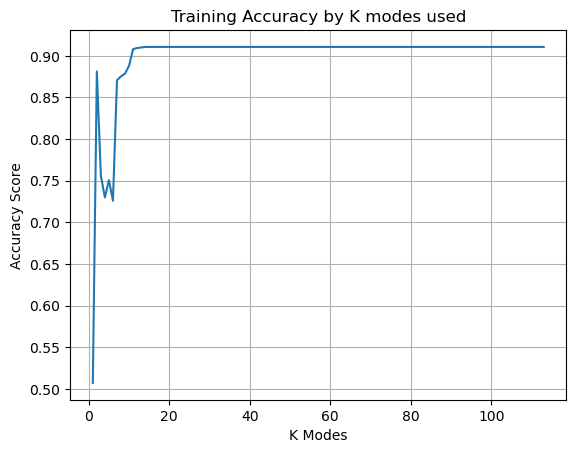

In [14]:
# Plot accuracy score by k value

ks = np.arange(1, 114)

plt.plot(ks, scores)
plt.grid(True)
plt.xlabel("K Modes")
plt.ylabel("Accuracy Score")
plt.title("Training Accuracy by K modes used")

Text(0.5, 1.0, 'Training Accuracy by K modes used')

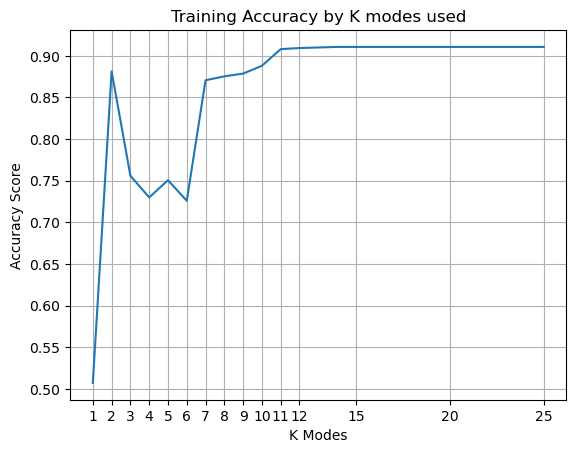

In [15]:
# Zoom in
ks = np.arange(1, 26)
plt.plot(ks, scores[:25])
plt.xlabel("K Modes")
plt.ylabel("Accuracy Score")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12, 15, 20, 25])
plt.grid(True)
plt.title("Training Accuracy by K modes used")

In [16]:
# Load test data into x_test

folder2 = "hw2data/test/"

names = ["walking", "running", "jumping"]

x_test = []
for action in names:
    file_path = os.path.join(folder2, action + "_1t.npy")
    x_test.append(np.load(file_path))

x_test = np.hstack(x_test)
test_truth_labels = np.hstack((np.full(100, 0), np.full(100, 1), np.full(100, 2)))
x_test.shape

(114, 300)

In [17]:
# Test data

# Determine optimal k for categorization prediction on test data

scores_test = []
# Determine accuracy score for each k

pca_project = np.dot(dU.T, x_train)
pca_test_project = np.dot(dU.T, x_test)
for k in range(1, 114):
    
    # Project x_train and x_test onto k modes pca space
    k_m_pca = pca_project[0:k, :]
    k_m_pca_test = pca_test_project[0:k, :]

    # Divide the projection by movement
    walking, running, jumping = np.split(k_m_pca, [500, 1000], axis=1)

    # Determine centroid in x_train for each movement
    centroids = np.array([np.mean(m, axis=1) for m in [walking, running, jumping]])
    
    # For each test sample assign label based on closest centroids in pca space
    dists = []
    for c in centroids:
        dists.append(np.linalg.norm(k_m_pca_test.T - c, axis=1))
    test_predict_labels = np.argmin(dists, axis=0)
    
    # Calculate accuracy score
    scores_test.append(accuracy_score(test_truth_labels, test_predict_labels))

Text(0.5, 1.0, 'Prediction Accuracy by K Modes Used')

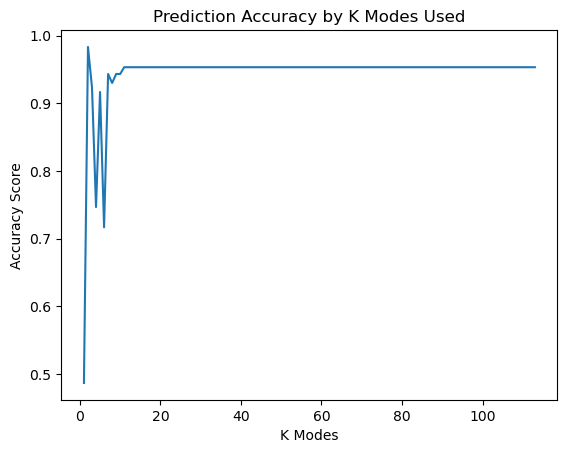

In [18]:
# Plot accuracy score by k value

ks = np.arange(1, 114)
plt.plot(ks, scores_test)
plt.xlabel("K Modes")
plt.ylabel("Accuracy Score")
plt.title("Prediction Accuracy by K Modes Used")

0.9533333333333334


Text(0.5, 1.0, 'Prediction Accuracy by K Modes Used')

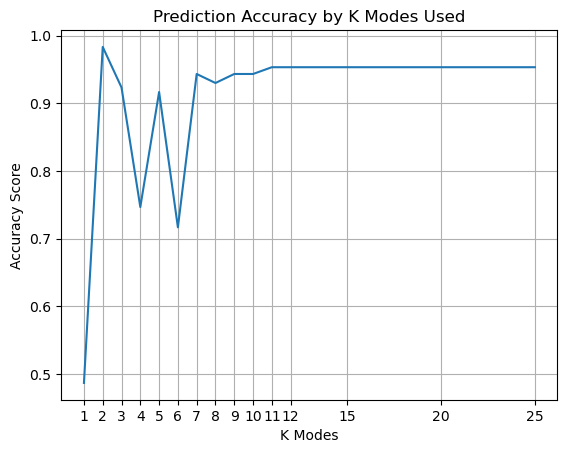

In [19]:
# Zoom in
mode = 12
print(scores_test[mode - 1])
ks = np.arange(1, 26)
plt.plot(ks, scores_test[:25])
plt.xlabel("K Modes")
plt.ylabel("Accuracy Score")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12, 15, 20, 25])
plt.grid(True)
plt.title("Prediction Accuracy by K Modes Used")